- Check for Colab Env
> if we are in colab env we need to get the data + scripts from github or somewhere

In [2]:
import os
if "COLAB_GPU" in os.environ:
    _useMultiProcessing = False
    os.system("git clone https://github.com/zaxo7/UNet-Playground.git")
    os.chdir("/content/UNet-Playground/")
else:
    _useMultiProcessing = True


- enable module autoreload and fix an import bug

In [3]:
%load_ext autoreload
%autoreload 2

import sys,os
sys.path.append(os.getcwd() + '/scripts')

- import the scripts and data

In [4]:
from scripts import data, model
import glob
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

2022-04-25 17:27:13.844012: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/zaxo7/tensorflow/lib/python3.8/site-packages/cv2/../../lib64:
2022-04-25 17:27:13.844055: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


- load the dataset
- and ceate image slices

- slice each image to small samples of size 188*188
- imgs -> rgb image
- mask -> mask
- edge -> edge_mask

In [5]:
train_img_files = glob.glob('data/train/*.jpg')
test_img_files = glob.glob('data/test/*.jpg')

train = model.generate_train_dataset(train_img_files)

train_generator = model.generate_train_dataset(train_img_files)

train_set = model.generate_train_dataset_tf(train_img_files)

test_img_chips, test_mask_chips, test_edge_chips = model.generate_test_dataset(test_img_files)

test_set = tf.data.Dataset.from_tensor_slices((test_img_chips, (test_mask_chips, test_edge_chips)))


2022-04-25 17:27:43.667971: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/zaxo7/tensorflow/lib/python3.8/site-packages/cv2/../../lib64:
2022-04-25 17:27:43.668017: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-25 17:27:43.668050: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (zx-d): /proc/driver/nvidia/version does not exist
2022-04-25 17:27:43.715874: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-25 17:27:46.378390: W te

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


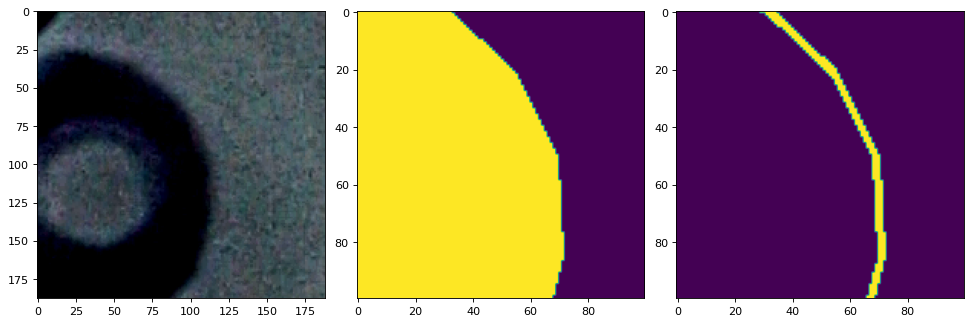

In [6]:
train_img_chips, (train_mask_chips, train_edge_chips) =  next(train_generator)

ind = 200
fig = plt.figure(figsize=(15, 10), dpi=80)
fig.subplots_adjust(hspace=0.1, wspace=0.1)
ax = fig.add_subplot(2, 3, 1)
ax.imshow(train_img_chips)
ax = fig.add_subplot(2, 3, 2)
ax.imshow(train_mask_chips)
ax = fig.add_subplot(2, 3, 3)
ax.imshow(train_edge_chips)

- create the model and compile it

In [7]:
unet = model.get_do_unet()

unet.compile(optimizer="adam",
             loss="binary_crossentropy",
             loss_weights=[0.3, 0.7],
             metrics=["acc"])

unet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 188, 188, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 186, 186, 96  2688        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 186, 186, 96  384        ['conv2d[0][0]']                 
 alization)                     )                                                             

- model parameters

In [8]:
_batch_size = 8
_epochs = 1
_workers = 8
_model_name = 'B'
images_per_epoch = 1000
train_steps = images_per_epoch//_batch_size
validation_steps = len(test_img_files)//_batch_size

- load weights

In [9]:
unet.load_weights(f"models/{_model_name}_best.h5")

- Train the model

In [ ]:


history = unet.fit(train_set.batch(_batch_size), 
         epochs=_epochs, 
         validation_data=test_set.batch(_batch_size), 
         steps_per_epoch=train_steps,
         max_queue_size=2*_workers,
         use_multiprocessing=_useMultiProcessing,
         workers=_workers,
         verbose=1,
         callbacks=model.get_callbacks(_model_name))

In [12]:
rand_index = np.random.randint(0, len(test_img_chips), 1)[0]
img = test_img_chips[rand_index]
mask = test_mask_chips[rand_index]
edge = test_edge_chips[rand_index]


img = np.array([np.squeeze(img)])

prediction = unet.predict(img)

prediction = np.squeeze(prediction)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


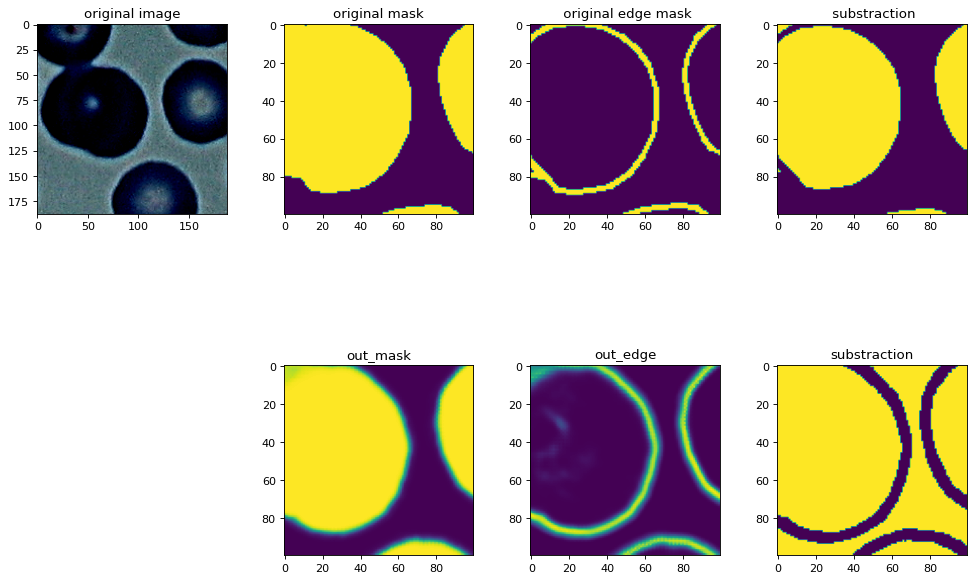

In [14]:
fig = plt.figure(figsize=(15, 10), dpi=80)
fig.subplots_adjust(hspace=0.3, wspace=0.3)
fig_num = 1
ax = fig.add_subplot(2, 4, fig_num)
ax.set_title("original image")
ax.imshow(img[0])
fig_num = fig_num + 1
ax = fig.add_subplot(2, 4, fig_num)
ax.set_title("original mask")
ax.imshow(mask)
fig_num = fig_num + 1
ax = fig.add_subplot(2, 4, fig_num)
ax.set_title(" original edge mask")
ax.imshow(edge)
fig_num = fig_num + 1
ax = fig.add_subplot(2, 4, fig_num)
ax.set_title(" substraction")
ax.imshow((mask - edge) > 0)


fig_num = fig_num + 2
ax = fig.add_subplot(2, 4, fig_num)
ax.set_title("out_mask")
ax.imshow(prediction[0])
fig_num = fig_num + 1
ax = fig.add_subplot(2, 4, fig_num)
ax.set_title("out_edge")
ax.imshow(prediction[1])
fig_num = fig_num + 1
ax = fig.add_subplot(2, 4, fig_num)
ax.set_title("substraction")
ax.imshow((prediction[0] - prediction[1]) > 0)




- show in between layers output

In [ ]:
ind = np.random.randint(0, 32, 1)[0]

_pool1 = pool1[:-1,:-1,ind]
_pool2 = pool2[:-1,:-1,ind]
_pool3 = pool3[:-1,:-1,ind]
_down4 = down4[:-1,:-1,ind]
_up1 = up1[:-1,:-1,ind]
_up2 = up2[:-1,:-1,ind]
_up3 = up3[:-1,:-1,ind]

fig = plt.figure(figsize=(15, 10), dpi=80)
fig.subplots_adjust(hspace=0.3, wspace=0.3)
fig_num = 1
ax = fig.add_subplot(3, 3, fig_num)
ax.set_title("out_mask")
ax.imshow(out_mask)
fig_num = fig_num + 1
ax = fig.add_subplot(3, 3, fig_num)
ax.set_title("out_edge")
ax.imshow(out_edge)
fig_num = fig_num + 1
ax = fig.add_subplot(3, 3, fig_num)
ax.set_title("pool1")
ax.imshow(_pool1)
fig_num = fig_num + 1
ax = fig.add_subplot(3, 3, fig_num)
ax.set_title("pool2")
ax.imshow(_pool2)
fig_num = fig_num + 1
ax = fig.add_subplot(3, 3, fig_num)
ax.set_title("pool3")
ax.imshow(_pool3)
fig_num = fig_num + 1
ax = fig.add_subplot(3, 3, fig_num)
ax.set_title("down4")
ax.imshow(_down4)
fig_num = fig_num + 1
ax = fig.add_subplot(3, 3, fig_num)
ax.set_title("up1")
ax.imshow(_up1)
fig_num = fig_num + 1
ax = fig.add_subplot(3, 3, fig_num)
ax.set_title("up2")
ax.imshow(_up2)
fig_num = fig_num + 1
ax = fig.add_subplot(3, 3, fig_num)
ax.set_title("up3")
ax.imshow(_up3)

- function to plot and array of images of shape (width, height, n_images)

In [90]:
def picshow(img, title):
    num = img.shape[2]
    imgs_per_line = 4
    ax = num//imgs_per_line + 1
    ay = imgs_per_line
    fig =plt.figure(figsize=(30, num//imgs_per_line * 10))
    fig.subplots_adjust(hspace=0.1, wspace=0.1)
    for i in range(1,num + 1):
        sub = fig.add_subplot(ax,ay,i)
        sub.set_title(f"{title} {i}")
        sub.imshow(img[:-1,:-1,i - 1])
    plt.show()
    



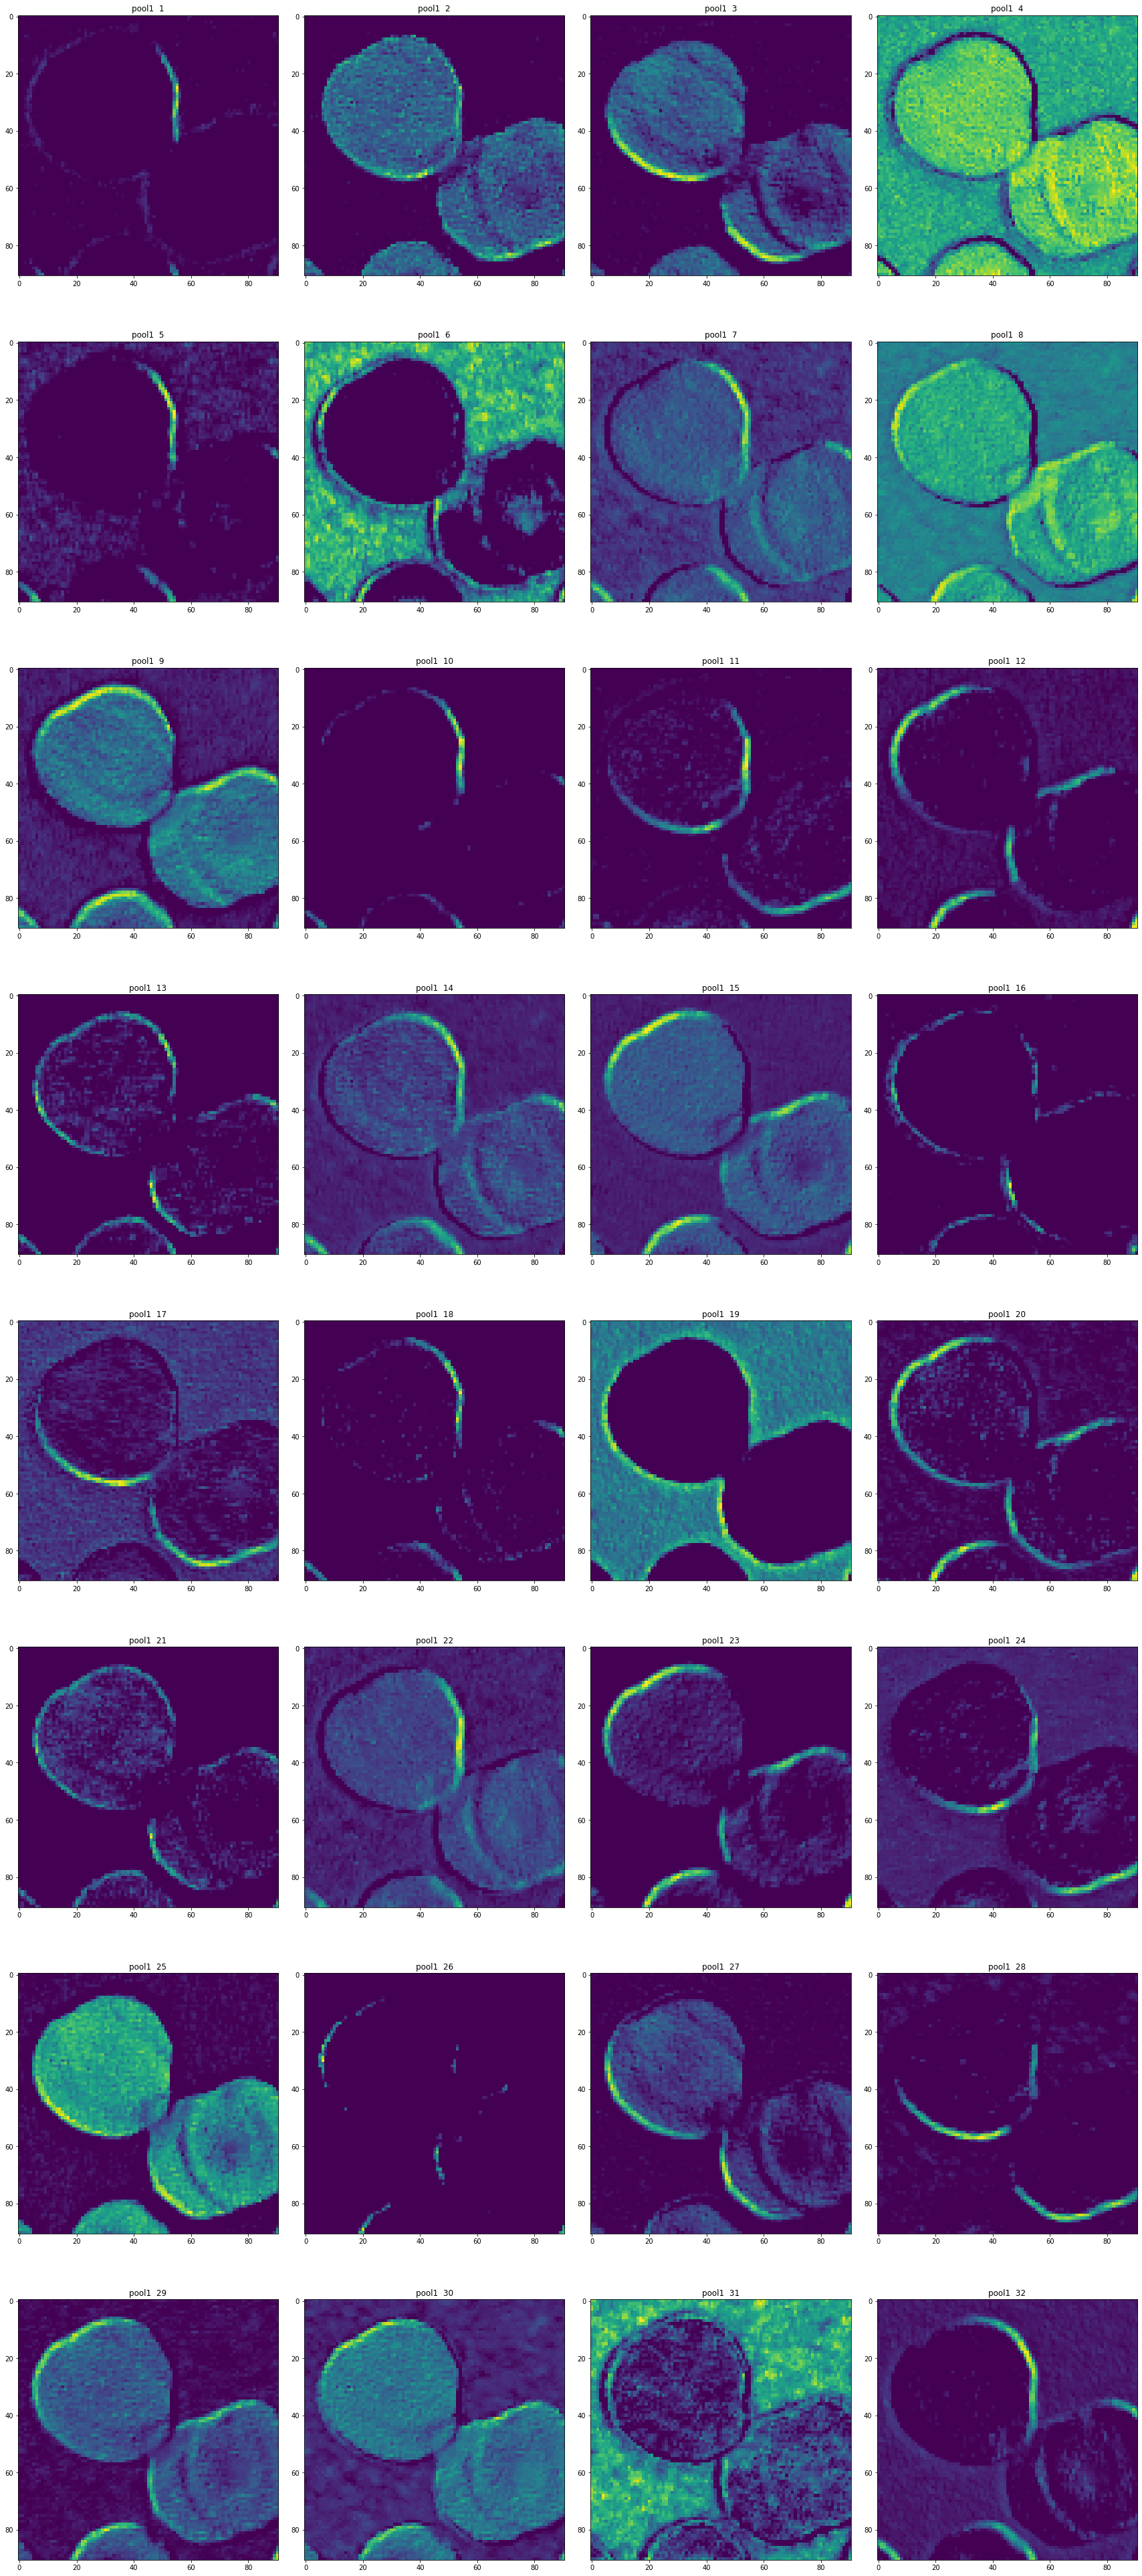

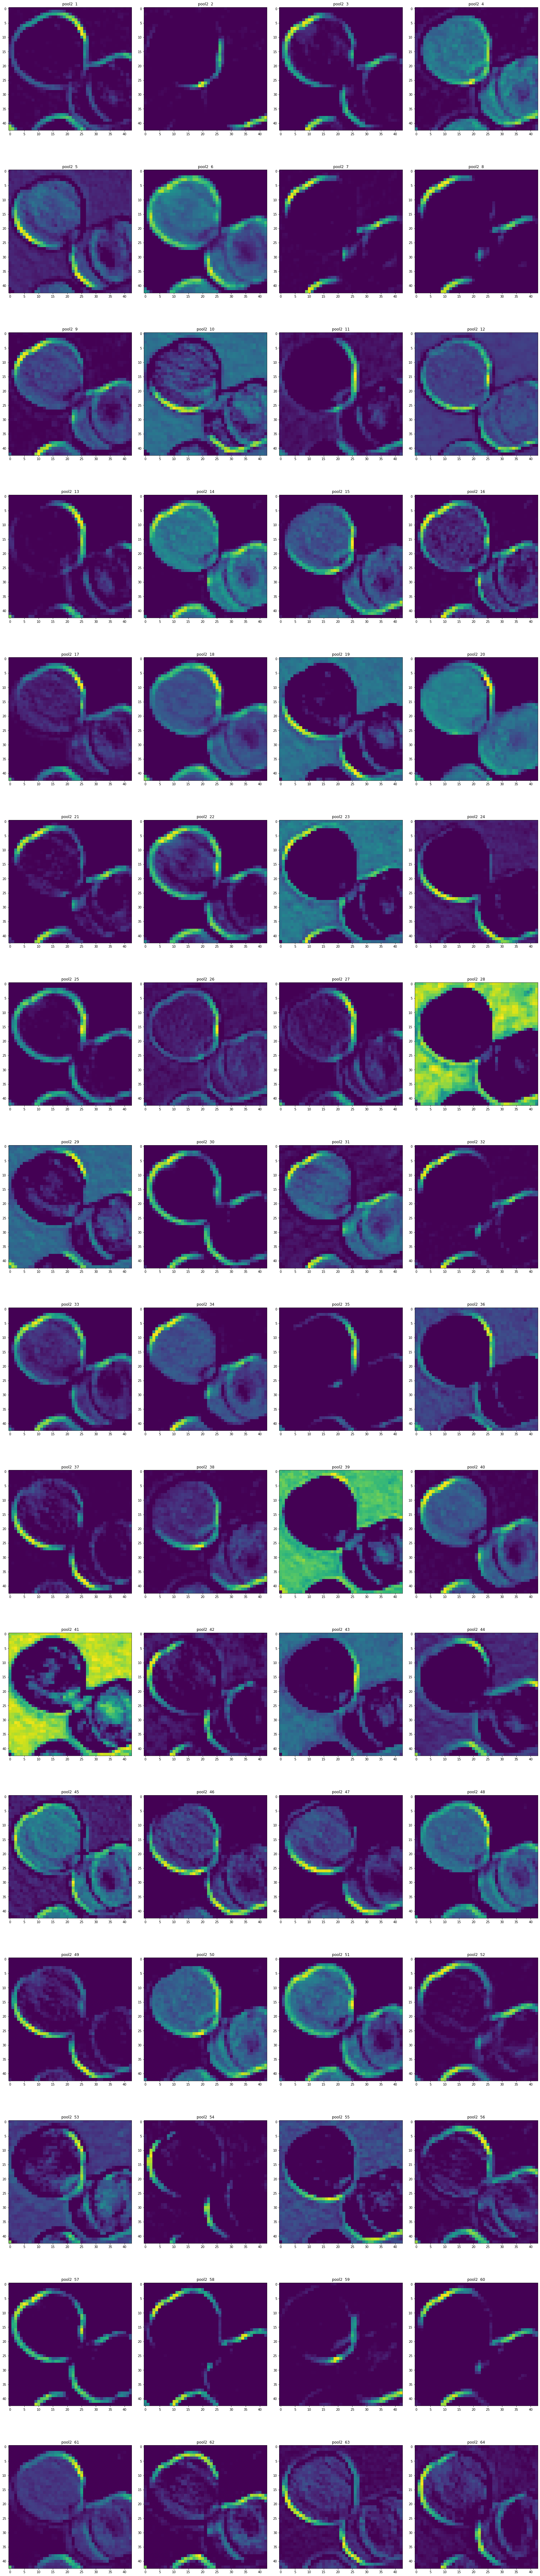

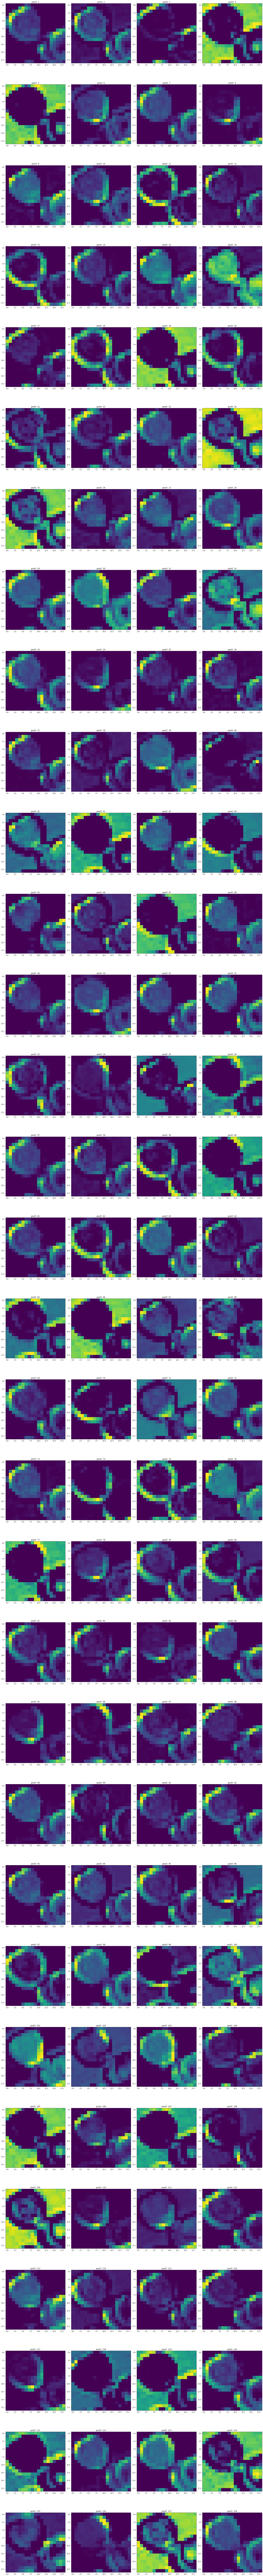

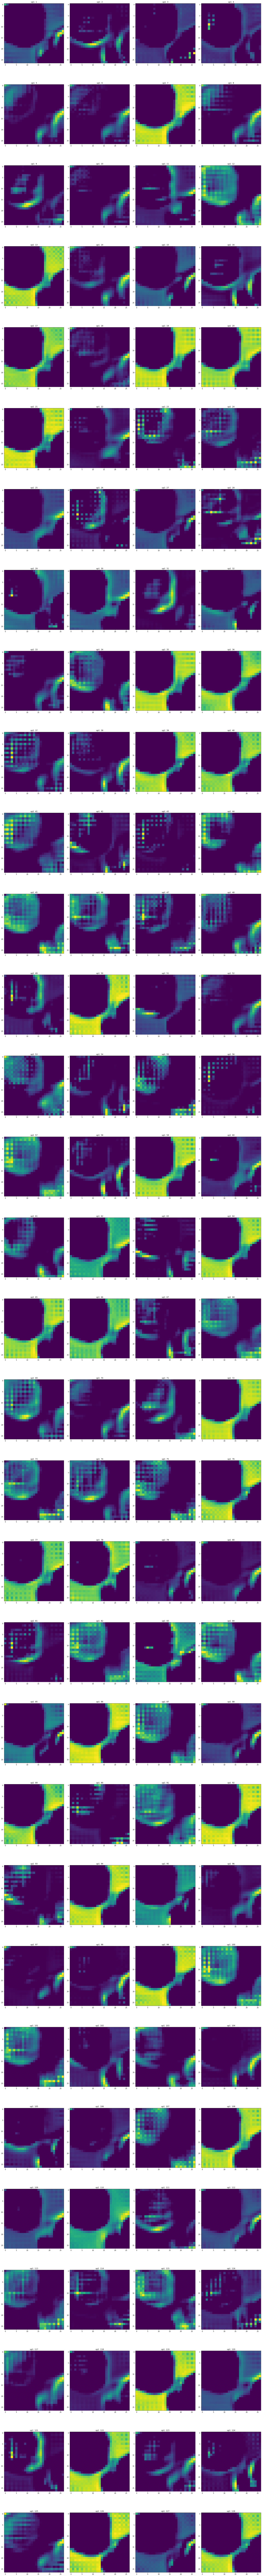

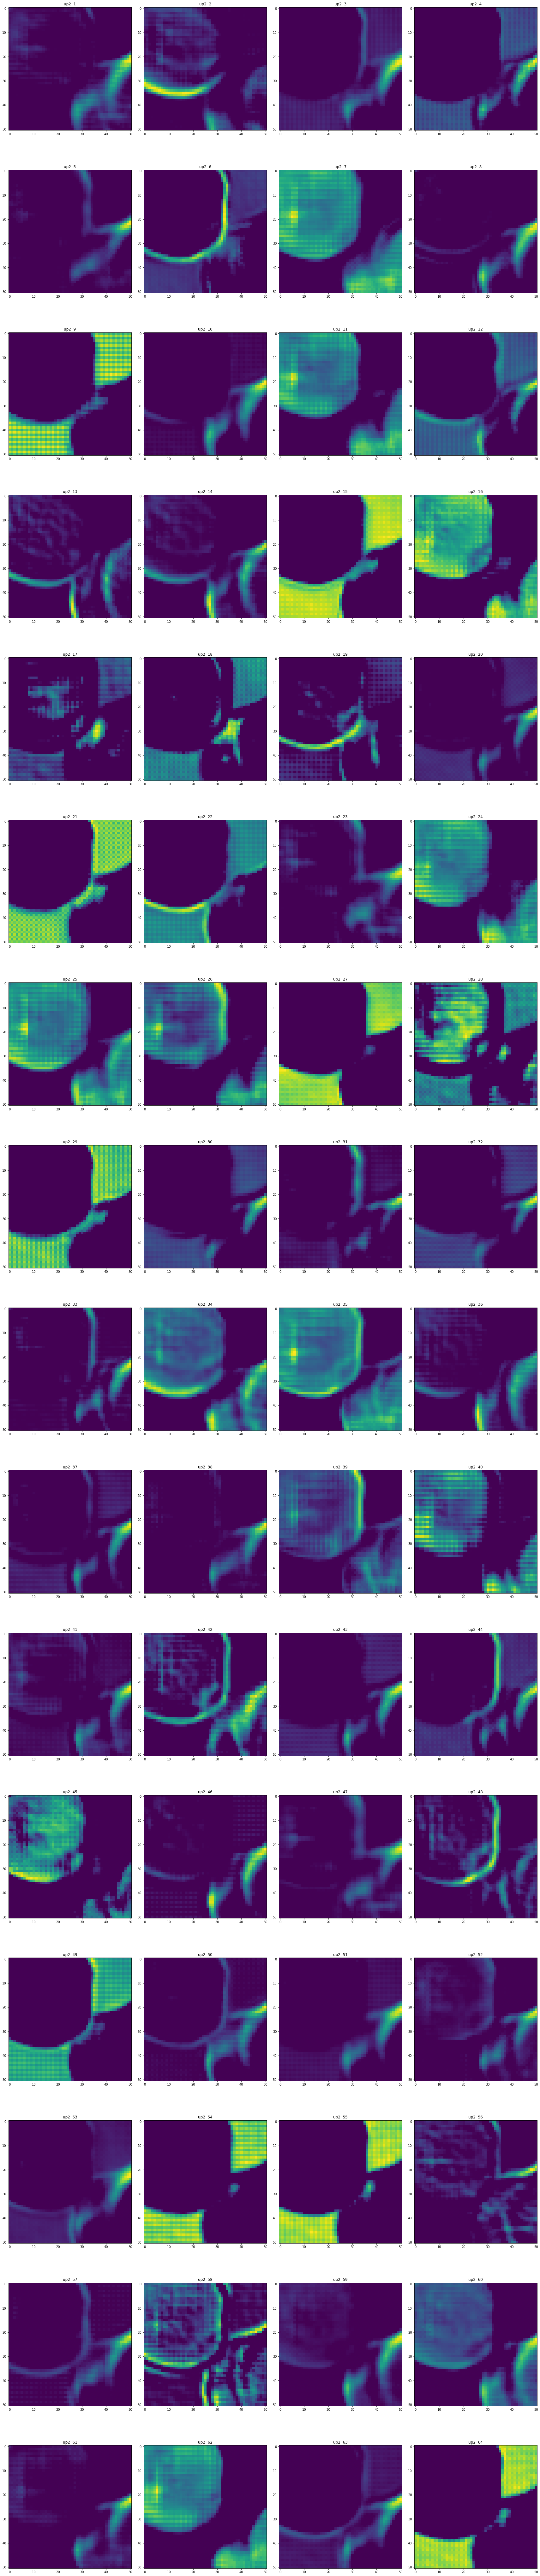

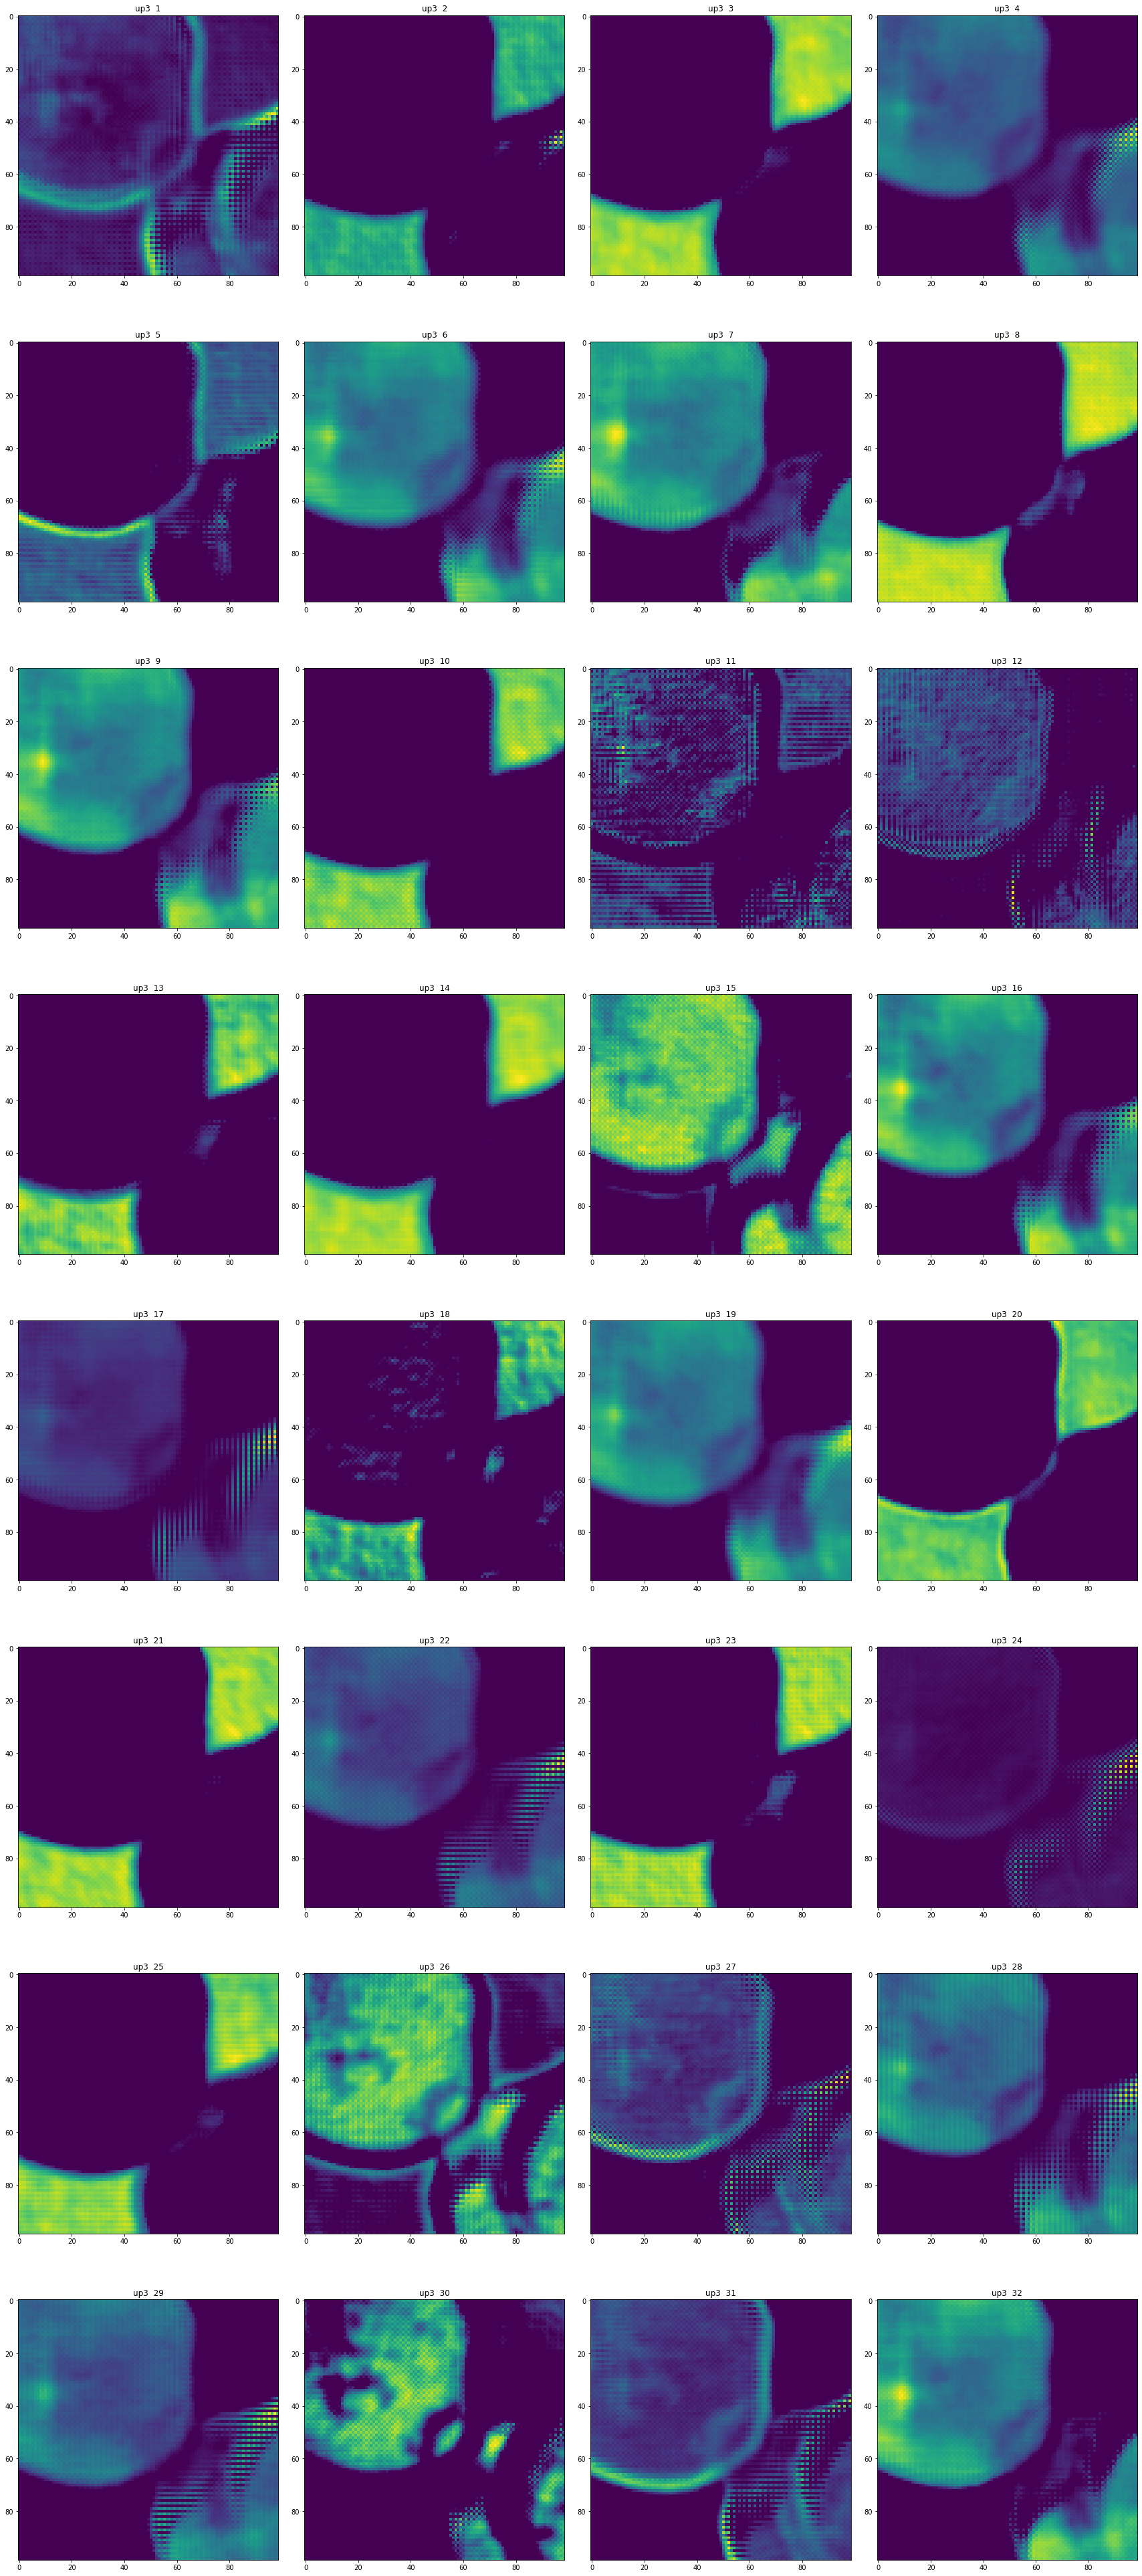

In [89]:
picshow(pool1, 'pool1 ')
picshow(pool2, 'pool2 ')
picshow(pool3, 'pool3 ')
picshow(down4, 'down4 ')
picshow(up1, 'up1 ')
picshow(up2, 'up2 ')
picshow(up3, 'up3 ')